# Performance of LLMs on the LAB-Bench benchmark
This notebook examines the performance of various large language models (LLMs) on the LAB-Bench dataset.

Hugging Face dataset: https://huggingface.co/datasets/futurehouse/lab-bench
* We use the CloningScenarios subset.

Paper: https://arxiv.org/abs/2407.10362

## Setup

In [25]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime
from datasets import load_dataset

In [26]:
results_df_path = 'results.csv'

log_files_dir = 'logs/'

model_dir_names = [
    'gpt-4o',
    'gemini-1.5-pro',
    'claude-3.5-sonnet',
    'llama-3.1-405b'
]

models_data_file = '../../../models/models_data.tsv'

large_scale_models_file = '../../../models/epoch-data/large_scale_ai_models.csv'
notable_models_file = '../../../models/epoch-data/notable_ai_models.csv'

## Process metadata
First, we merge two Epoch datasets containing model metadata into a single dataframe. 

[1] https://epochai.org/data/large-scale-ai-models  
[2] https://epochai.org/data/notable-ai-models

Then, we merge the Epoch data with manually collected model metadata.

In [27]:
def merge_epoch_datasets(notable_file, large_scale_file):
    """"""
    
    notable_df = pd.read_csv(notable_file)
    large_scale_df = pd.read_csv(large_scale_file)
    epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
    epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')
    return epoch_df

epoch_data = merge_epoch_datasets(notable_models_file, large_scale_models_file)

In [28]:
models_df = pd.read_csv(models_data_file, sep='\t')

# models_metadata = models_df.merge(epoch_data, left_on='epoch_model_name', right_on='System', how='left')

## Load results from Inspect
Load the contents of a log directory into a dataframe and compute estimated cost per run.

In [29]:
def clean_cost(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

def calculate_cost(input_tokens, output_tokens, model_name, models_df):
    model_data = models_df[models_df['inspect_model_name'] == model_name].iloc[0]
    input_cost_per_M = clean_cost(model_data['input_cost_per_M_tokens'])
    output_cost_per_M = clean_cost(model_data['output_cost_per_M_tokens'])
    cost_per_M = clean_cost(model_data['cost_per_M_tokens'])
    
    if input_cost_per_M and output_cost_per_M:
        input_cost = (input_cost_per_M / 1_000_000) * input_tokens
        output_cost = (output_cost_per_M / 1_000_000) * output_tokens
        total_cost = input_cost + output_cost
    elif cost_per_M:
        total_cost = (cost_per_M / 1_000_000) * (input_tokens + output_tokens)
    else:
        total_cost = 0
    
    return round(total_cost, 2)

def process_log_files(log_files_dir, model_dir_names):
    results = []
    
    for model_dir in model_dir_names:
        log_path = os.path.join(log_files_dir, model_dir)
        for filename in os.listdir(log_path):
            if filename.endswith('.json'):
                file_path = os.path.join(log_path, filename)
                with open(file_path, 'r') as f:
                    log = json.load(f)
                
                if log['status'] == "success":
                    model_name = log['eval']['model']
                    
                    # Extract data from logs
                    accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                    stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                    token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                    task_name = log['eval']['task']
                    dataset_samples = log['eval']['dataset']['samples']
                    completed_samples = log['results']['completed_samples']
                    input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                    output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                    start_time = log['stats']['started_at']
                    end_time = log['stats']['completed_at']
                    
                    # Calculate cost for this run
                    run_cost = calculate_cost(input_tokens, output_tokens, model_name, models_df)
                    
                    results.append({
                        'inspect_model_name': model_name,
                        'accuracy': accuracy,
                        'stderr': stderr,
                        'total_tokens': token_usage,
                        'input_tokens': input_tokens,
                        'output_tokens': output_tokens,
                        'task': task_name,
                        'dataset_samples': dataset_samples,
                        'completed_samples': completed_samples,
                        'run_id': log['eval']['run_id'],
                        'created': log['eval']['created'],
                        'start_time': start_time,
                        'end_time': end_time,
                        'filename': filename,
                        'estimated_cost': run_cost
                    })
        
    return pd.DataFrame(results)

results_df = process_log_files(log_files_dir, model_dir_names)

In [31]:
cloning_df = results_df.merge(models_df, left_on='inspect_model_name', right_on='inspect_model_name', how='left')
cloning_df.to_csv(results_df_path, index=False)
cloning_df.head()

,inspect_model_name,accuracy,stderr,total_tokens,input_tokens,output_tokens,task,dataset_samples,completed_samples,run_id,...,filename,estimated_cost,epoch_model_name,biggest_in_class,cost_per_M_tokens,input_cost_per_M_tokens,output_cost_per_M_tokens,cost_source,api_source,last_updated
0,openai/gpt-4o,0.363636,0.085038,197550,197451,99,benchmarks/lab_bench,33,33,48VNCJtTxAMqtzf8bTTvRK,...,2024-10-03T08-44-44-04-00_benchmarks-lab-bench...,0.99,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
1,openai/gpt-4o,0.363636,0.085038,197551,197452,99,benchmarks/lab_bench,33,33,A975uH49MbSFwXTAuAdY5i,...,2024-10-03T08-45-06-04-00_benchmarks-lab-bench...,0.99,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
2,openai/gpt-4o,0.484848,0.088348,197555,197452,103,benchmarks/lab_bench,33,33,avbBbeUZf8tB44Manrth9g,...,2024-10-03T08-44-35-04-00_benchmarks-lab-bench...,0.99,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
3,openai/gpt-4o,0.363636,0.085038,197551,197452,99,benchmarks/lab_bench,33,33,EEyX9VnPXSumvohDv6jYJQ,...,2024-10-03T08-44-40-04-00_benchmarks-lab-bench...,0.99,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03
4,openai/gpt-4o,0.484848,0.088348,197550,197451,99,benchmarks/lab_bench,33,33,j9xqVaNS4pTgiSkb9ko7r3,...,2024-10-03T08-44-49-04-00_benchmarks-lab-bench...,0.99,GPT-4o,1,NaN,$5.00,$15.00,https://openai.com/api/pricing/,"https://platform.openai.com/docs/models, https...",2024-09-03


## Cost analysis

In [32]:
cost_summary = cloning_df.groupby('inspect_model_name').agg({
    'estimated_cost': ['count', 'sum', 'mean'],
    'input_tokens': 'sum',
    'output_tokens': 'sum'
}).reset_index()
cost_summary.head()

cost_summary.columns = [
    'Model', 'Total Runs', 'Estimated Total Cost', 'Estimated Average Cost per Run',
    'Total Input Tokens', 'Total Output Tokens'
]

cost_summary = cost_summary[[
    'Model', 'Total Runs', 'Total Input Tokens', 'Total Output Tokens',
    'Estimated Total Cost', 'Estimated Average Cost per Run'
]]

print("Cost Analysis for LAB-Bench CloningScenarios Benchmark:")
print(cost_summary.to_string(index=False))

# Calculate and display the grand total cost
grand_total_cost = cost_summary['Estimated Total Cost'].sum()
print(f"\nEstimated Total Cost for all models: ${grand_total_cost:.2f}")

Cost Analysis for LAB-Bench CloningScenarios Benchmark:
                                                 Model  Total Runs  Total Input Tokens  Total Output Tokens  Estimated Total Cost  Estimated Average Cost per Run
                  anthropic/claude-3-5-sonnet-20240620          10             2150790                 1992                  6.50                           0.650
                                 google/gemini-1.5-pro          10             1612640                  992                  5.70                           0.570
                                         openai/gpt-4o          10             1974519                 1002                  9.90                           0.990
together/meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo          10             1977032                37400                 10.05                           1.005

Estimated Total Cost for all models: $32.15


In [33]:
def compute_cloning_random_baseline():
    # Load the LitQA2 dataset
    dataset = load_dataset("futurehouse/lab-bench", name="CloningScenarios", split="train")
    
    # Calculate the number of options for each question
    num_options = [len(record['distractors']) + 1 for record in dataset]  # +1 for the correct answer
    
    # Calculate the probability of guessing correctly for each question
    probabilities = [1/n for n in num_options]
    
    # Compute the average probability
    random_guess_baseline = np.mean(probabilities)
    
    return random_guess_baseline

# Call the function and print the result
baseline = compute_cloning_random_baseline()
print(f"Random guess baseline accuracy for CloningScenarios: {baseline:.4f}")

Random guess baseline accuracy for CloningScenarios: 0.2259


<Figure size 1200x800 with 0 Axes>

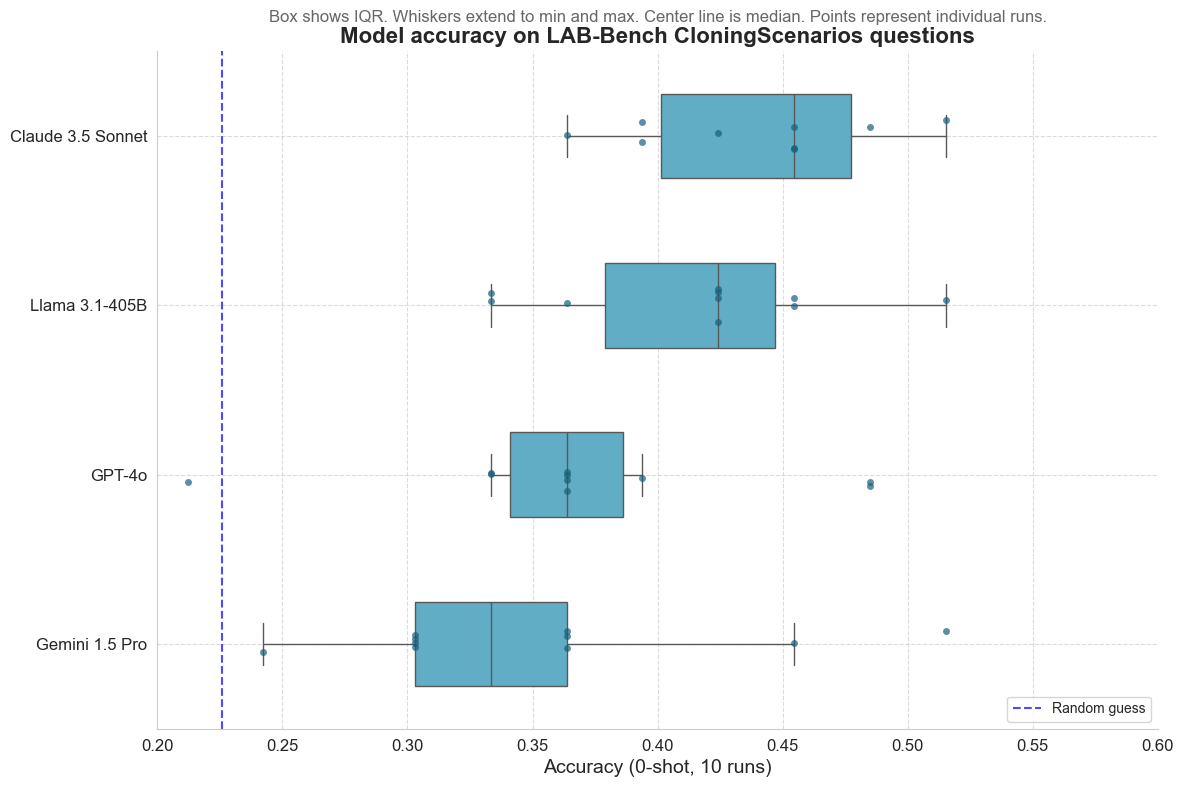

In [23]:
# Set up the plot style
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
box_color = '#4FB6D6'
point_color = '#1A5F7A'

# Create box plot
sns.boxplot(x='accuracy', y='epoch_model_name', data=cloning_df, 
            ax=ax, color=box_color, width=0.5, 
            showfliers=False, order=cloning_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Add jittered points
sns.stripplot(x='accuracy', y='epoch_model_name', data=cloning_df, 
              ax=ax, color=point_color, alpha=0.7, size=5, 
              jitter=True, order=cloning_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index)

# Customize the plot
ax.set_xlabel('Accuracy (0-shot, 10 runs)', fontsize=14)
ax.set_ylabel('')
ax.set_xlim(0.2, 0.6)

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add reference lines
ax.axvline(x=baseline, color='blue', linestyle='--', alpha=0.7, label='Random guess')

# Add legend
ax.legend(fontsize=10, loc='lower right')

# Add title
plt.title('Model accuracy on LAB-Bench CloningScenarios questions', fontsize=16, fontweight='bold')

# Add subtitle
plt.text(0.5, 1.05, 'Box shows IQR. Whiskers extend to min and max. Center line is median. Points represent individual runs.',
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12, alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.savefig('cloningscenarios_accuracy_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()